Random seed fixed for reproducibility

=== STEP 1: PARAMETER INITIALIZATION ===
fs=16000 Hz  duration=3 s  N=48000
Array: 6 mics, spacing=5.0 cm
Target: 60°  Interferer: 120° (from broadside)

=== STEP 2: SIGNAL GENERATION ===
Target length=48000,  Interferer length=48000

=== STEP 3: DELAY CALCULATION ===
Target delay (samples): [ 0  2  4  6  8 10]
Interferer delay (samples): [ 0  2  4  6  8 10]

=== STEP 4: MICROPHONE SIGNAL GENERATION ===
received shape: (48000, 6)

=== STEP 5: STEERING VECTOR DEFINED ===

=== STEP 5: STFT PARAMETERS ===
STFT/ISTFT self-test error = 2.49e-16
✓ STFT/ISTFT OK

=== STEP 6: MVDR BEAMFORMING ===
STFT shape: (257, 189, 6)  (freq_bins x frames x mics)
Frequency-domain processing complete

=== STEP 7: RECONSTRUCTION ===
beamformed_ds length=48000,  beamformed_mvdr length=48000

=== VERIFYING FREQUENCY-DOMAIN DS ===
Correlation (ref DS vs freq-domain DS): 0.9995
✓ DS correct

=== DIAGNOSTICS ===
  Target  std=0.468
  Mic 1   std=0.271
  DS out  std=0.271
  M

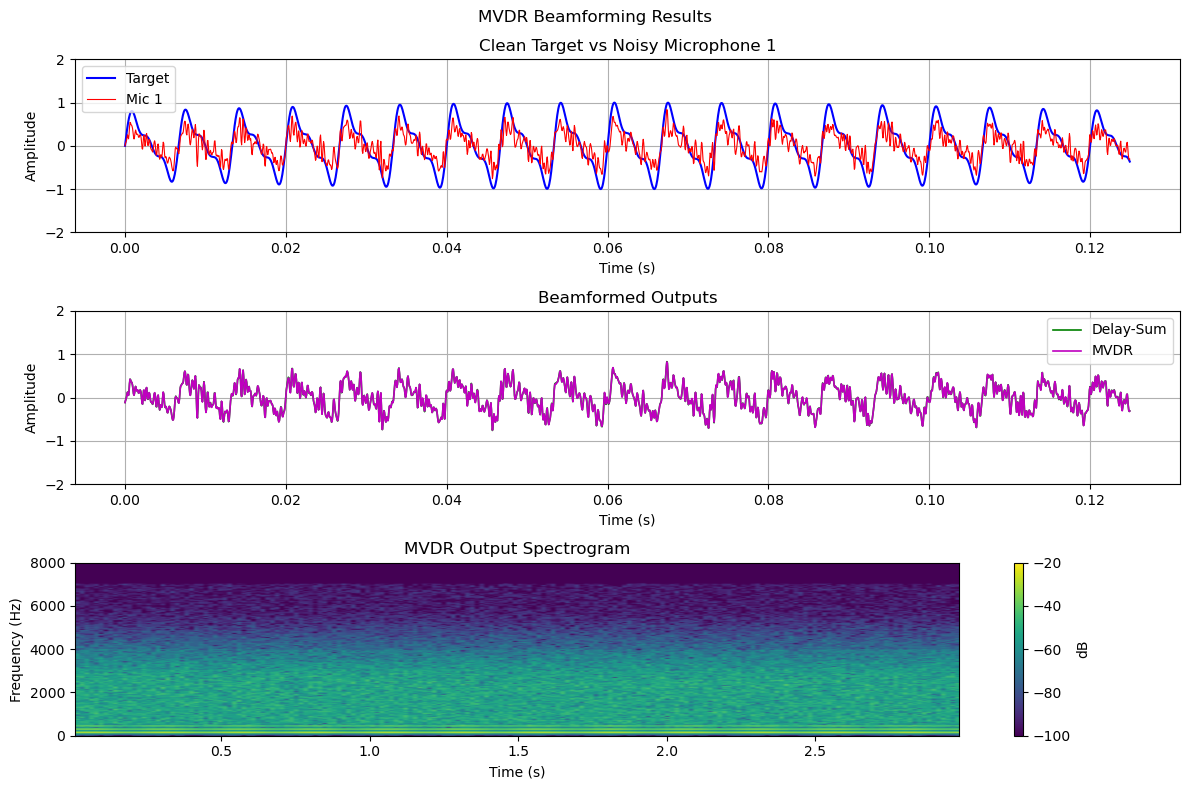

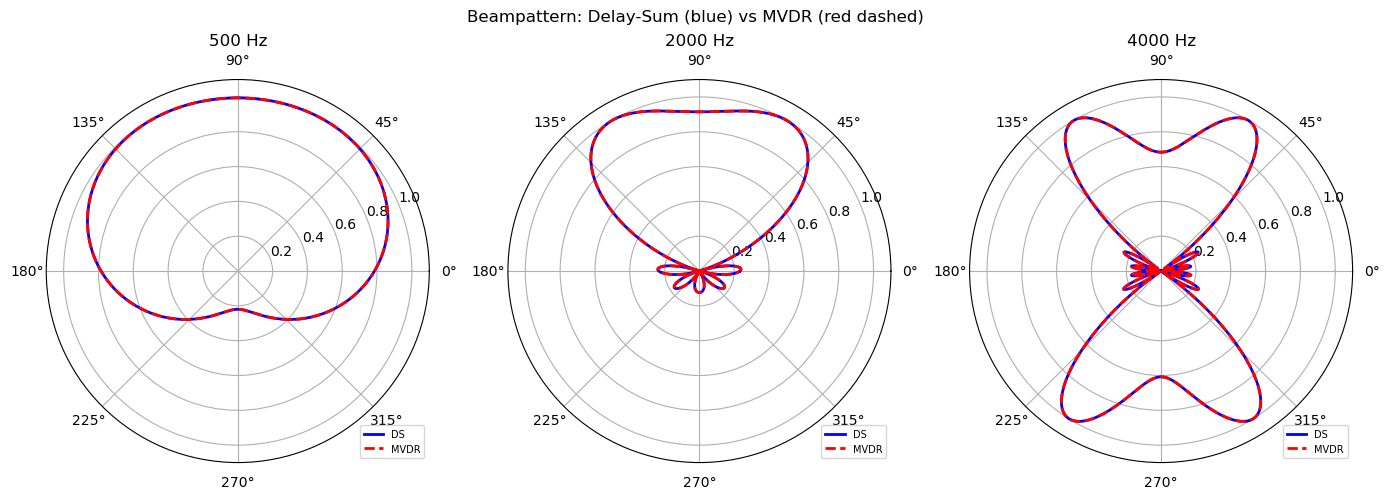

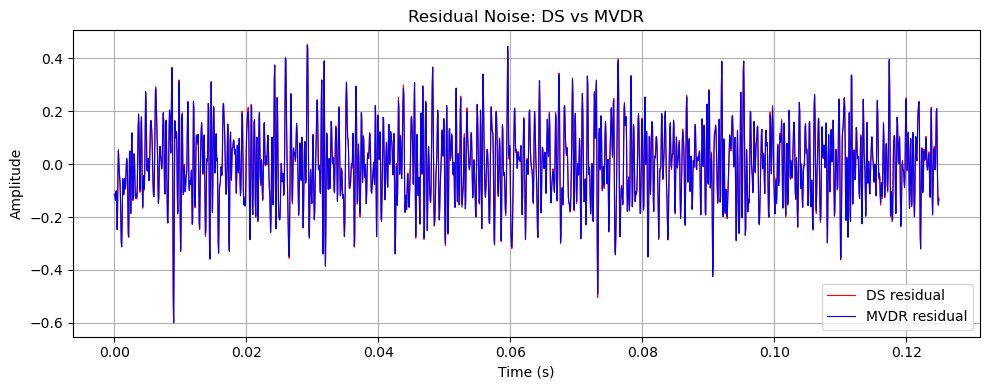

In [1]:
"""
MVDR BEAMFORMING – Python Version
==================================
Uniform linear array (ULA) with M microphones.
Target at 60°, interferer at 120° (angles from BROADSIDE).

Theoretical conventions:
  1. Steering vector: exp(-j*2*pi*f*tau),  tau = mic_pos*sin(angle)/c
  2. DS weights:      w = d / M
  3. Beamformer output: y = w^H x  →  X_f @ np.conj(w)
  4. MVDR weights:    w = R^{-1}d / (d^H R^{-1} d)
  5. Covariance:      R = X^H X / T  (Hermitian, PSD)
  6. Regularisation:  R_reg = R + eps*(trace(R)/M)*I
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, correlate, ShortTimeFFT
from scipy.signal.windows import hann
from scipy.linalg import cho_factor, cho_solve, LinAlgError
import warnings

# ── reproducibility ──────────────────────────────────────────────────────────
rng = np.random.default_rng(42)
print("Random seed fixed for reproducibility")

# =============================================================================
# STEP 1 – PARAMETERS
# =============================================================================
print("\n=== STEP 1: PARAMETER INITIALIZATION ===")

c        = 343          # speed of sound (m/s)
fs       = 16000        # sampling frequency (Hz)
duration = 3            # seconds
N        = fs * duration

# Array geometry
M       = 6
d_space = 0.05                              # inter-element spacing (m)
mic_pos = np.arange(M) * d_space            # shape (M,)

# Directions (from BROADSIDE)
target_angle = 60    # degrees
interf_angle = 120   # degrees

target_dist = 2.0
interf_dist = 2.5

print(f"fs={fs} Hz  duration={duration} s  N={N}")
print(f"Array: {M} mics, spacing={d_space*100:.1f} cm")
print(f"Target: {target_angle}°  Interferer: {interf_angle}° (from broadside)")

# =============================================================================
# STEP 2 – SIGNAL GENERATION
# =============================================================================
print("\n=== STEP 2: SIGNAL GENERATION ===")

t = np.arange(N) / fs                       # shape (N,)

# Target – speech-like harmonic
f0     = 150
target = (  np.sin(2*np.pi*f0*t)
          + 0.5*np.sin(2*np.pi*2*f0*t)
          + 0.3*np.sin(2*np.pi*3*f0*t) )
target *= (0.8 + 0.2*np.sin(2*np.pi*4*t))
target /= np.max(np.abs(target))

# Interferer – bandpass noise
interf = rng.standard_normal(N)
b, a   = butter(4, [500/(fs/2), 3000/(fs/2)], btype='bandpass')
interf = lfilter(b, a, interf)
interf = interf / np.max(np.abs(interf)) * 1.5

print(f"Target length={len(target)},  Interferer length={len(interf)}")

# =============================================================================
# STEP 3 – DELAYS
# =============================================================================
print("\n=== STEP 3: DELAY CALCULATION ===")

# Broadside convention: tau_m = mic_pos[m] * sin(angle) / c
target_delays      = mic_pos * np.sin(np.deg2rad(target_angle)) / c
interf_delays      = mic_pos * np.sin(np.deg2rad(interf_angle)) / c
target_delay_samps = np.round(target_delays * fs).astype(int)
interf_delay_samps = np.round(interf_delays * fs).astype(int)

target_atten = 1.0 / target_dist
interf_atten = 1.0 / interf_dist

print(f"Target delay (samples): {target_delay_samps}")
print(f"Interferer delay (samples): {interf_delay_samps}")

# =============================================================================
# STEP 4 – MICROPHONE SIGNALS
# =============================================================================
print("\n=== STEP 4: MICROPHONE SIGNAL GENERATION ===")

def apply_delay(sig, delay_samps):
    """Integer-sample delay (positive = delay, negative = advance)."""
    out = np.zeros_like(sig)
    d   = int(delay_samps)
    if d > 0:
        out[d:] = sig[:-d]
    elif d < 0:
        out[:d] = sig[-d:]
    else:
        out = sig.copy()
    return out

received = np.zeros((N, M))
for m in range(M):
    received[:, m] += target_atten * apply_delay(target, target_delay_samps[m])
    received[:, m] += interf_atten * apply_delay(interf, interf_delay_samps[m])

received += 0.005 * rng.standard_normal((N, M))
print(f"received shape: {received.shape}")

# =============================================================================
# STEERING VECTOR
# =============================================================================
def steering_vector(mic_pos, angle_deg, freq, c):
    """
    d[m] = exp(-j * 2*pi*f * tau_m),  tau_m = mic_pos[m]*sin(angle)/c
    Shape: (M,)  complex
    """
    tau = mic_pos * np.sin(np.deg2rad(angle_deg)) / c
    return np.exp(-1j * 2 * np.pi * freq * tau)

print("\n=== STEP 5: STEERING VECTOR DEFINED ===")

# =============================================================================
# STEP 5 – STFT
# =============================================================================
print("\n=== STEP 5: STFT PARAMETERS ===")

win_len  = 512
hop      = 256
window   = hann(win_len, sym=False)          # periodic Hann

# Use scipy ShortTimeFFT for STFT/ISTFT
SFT      = ShortTimeFFT(window, hop=hop, fs=fs, mfft=win_len, fft_mode='onesided')
n_freq   = win_len // 2 + 1

# Quick self-test
test_sig  = rng.standard_normal(N)
S_test    = SFT.stft(test_sig)
test_rec  = SFT.istft(S_test, k1=N)
recon_err = np.linalg.norm(test_sig - test_rec) / np.linalg.norm(test_sig)
print(f"STFT/ISTFT self-test error = {recon_err:.2e}")
print("✓ STFT/ISTFT OK" if recon_err < 1e-4 else "WARNING: reconstruction error high")

# =============================================================================
# STEP 6 – MVDR BEAMFORMING
# =============================================================================
print("\n=== STEP 6: MVDR BEAMFORMING ===")

# Compute STFT for every channel  →  X shape: (n_freq, n_frames, M)
X0 = SFT.stft(received[:, 0])
n_frames = X0.shape[1]
X  = np.zeros((n_freq, n_frames, M), dtype=complex)
X[:, :, 0] = X0
for m in range(1, M):
    X[:, :, m] = SFT.stft(received[:, m])

print(f"STFT shape: {X.shape}  (freq_bins x frames x mics)")

Y_ds   = np.zeros((n_freq, n_frames), dtype=complex)
Y_mvdr = np.zeros((n_freq, n_frames), dtype=complex)

REG = 0.01     # diagonal-loading factor (relative to trace(R)/M)

for f_idx in range(n_freq):
    freq = f_idx * fs / win_len           # Hz
    if freq < 100 or freq > 7000:
        continue

    X_f   = X[f_idx, :, :]               # shape (n_frames, M)
    d_tgt = steering_vector(mic_pos, target_angle, freq, c)   # (M,)

    # ── Delay-Sum weights ────────────────────────────────────────────────────
    # w_DS = d / M  →  distortionless: w^H d = d^H d / M = M/M = 1
    w_ds = d_tgt / M                      # (M,)

    # ── Sample covariance  R = X^H X / T ────────────────────────────────────
    # X_f is (T x M);  X_f.conj().T @ X_f  gives (M x M) Hermitian PSD matrix
    R     = (X_f.conj().T @ X_f) / n_frames
    R_reg = R + REG * (np.trace(R).real / M) * np.eye(M)

    # ── MVDR weights  w = R^{-1}d / (d^H R^{-1} d) ──────────────────────────
    try:
        c_fac, lower = cho_factor(R_reg, lower=True)
        R_inv_d      = cho_solve((c_fac, lower), d_tgt)
        denom        = np.real(d_tgt.conj() @ R_inv_d)   # real positive scalar
        w_mvdr       = R_inv_d / denom
        if not np.all(np.isfinite(w_mvdr)) or np.linalg.norm(w_mvdr) > 1e4:
            raise ValueError("Numerical issue")
    except (LinAlgError, ValueError):
        w_mvdr = w_ds                     # fall back to DS

    # ── Apply weights:  y = w^H x  →  X_f @ conj(w) ─────────────────────────
    Y_ds[f_idx, :]   = X_f @ np.conj(w_ds)
    Y_mvdr[f_idx, :] = X_f @ np.conj(w_mvdr)

print("Frequency-domain processing complete")

# =============================================================================
# STEP 7 – TIME-DOMAIN RECONSTRUCTION
# =============================================================================
print("\n=== STEP 7: RECONSTRUCTION ===")

beamformed_ds   = SFT.istft(Y_ds,   k1=N)
beamformed_mvdr = SFT.istft(Y_mvdr, k1=N)

# Trim / zero-pad to exactly N samples
def trim_pad(x, n):
    if len(x) >= n:
        return x[:n]
    return np.concatenate([x, np.zeros(n - len(x))])

beamformed_ds   = trim_pad(beamformed_ds,   N)
beamformed_mvdr = trim_pad(beamformed_mvdr, N)
print(f"beamformed_ds length={len(beamformed_ds)},  beamformed_mvdr length={len(beamformed_mvdr)}")

# =============================================================================
# VERIFY DS
# =============================================================================
print("\n=== VERIFYING FREQUENCY-DOMAIN DS ===")

ref_ds    = np.zeros(N)
min_delay = int(np.min(target_delay_samps))
for m in range(M):
    shift = int(target_delay_samps[m]) - min_delay
    if shift > 0:
        ref_ds[:N-shift] += received[shift:, m]
    else:
        ref_ds += received[:, m]
ref_ds /= M

seg      = slice(5000, 15000)
corr_mat = np.corrcoef(ref_ds[seg], beamformed_ds[seg])
print(f"Correlation (ref DS vs freq-domain DS): {corr_mat[0,1]:.4f}")
print("✓ DS correct" if corr_mat[0, 1] >= 0.99 else "WARNING: DS mismatch")

# =============================================================================
# DIAGNOSTICS
# =============================================================================
print("\n=== DIAGNOSTICS ===")
print(f"  Target  std={np.std(target):.3f}")
print(f"  Mic 1   std={np.std(received[:,0]):.3f}")
print(f"  DS out  std={np.std(beamformed_ds):.3f}")
print(f"  MVDR    std={np.std(beamformed_mvdr):.3f}")

def xcorr_peak_lag(a, b):
    """Return lag (samples) of peak cross-correlation."""
    cc  = correlate(a, b, mode='full')
    lag = np.argmax(np.abs(cc)) - (len(b) - 1)
    return lag

lag_ds   = xcorr_peak_lag(beamformed_ds,   target)
lag_mvdr = xcorr_peak_lag(beamformed_mvdr, target)
print(f"Peak lag – DS: {lag_ds} samples,  MVDR: {lag_mvdr} samples")

# =============================================================================
# STEP 8 – PLOTS
# =============================================================================
print("\n=== STEP 8: PLOTTING ===")

plot_len = min(2000, N)
t_plot   = t[:plot_len]

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

axes[0].plot(t_plot, target[:plot_len],        'b', lw=1.5, label='Target')
axes[0].plot(t_plot, received[:plot_len, 0],   'r', lw=0.8, label='Mic 1')
axes[0].set(title='Clean Target vs Noisy Microphone 1', xlabel='Time (s)',
            ylabel='Amplitude', ylim=[-2, 2])
axes[0].legend(); axes[0].grid(True)

axes[1].plot(t_plot, beamformed_ds[:plot_len],   'g', lw=1.2, label='Delay-Sum')
axes[1].plot(t_plot, beamformed_mvdr[:plot_len], 'm', lw=1.2, label='MVDR')
axes[1].set(title='Beamformed Outputs', xlabel='Time (s)',
            ylabel='Amplitude', ylim=[-2, 2])
axes[1].legend(); axes[1].grid(True)

# Spectrogram of MVDR output
axes[2].specgram(beamformed_mvdr, NFFT=512, Fs=fs, noverlap=256,
                 vmin=-100, vmax=-20, cmap='viridis')
axes[2].set(title='MVDR Output Spectrogram', xlabel='Time (s)', ylabel='Frequency (Hz)')
plt.colorbar(axes[2].images[0], ax=axes[2], label='dB')

fig.suptitle('MVDR Beamforming Results')
plt.tight_layout()

# =============================================================================
# STEP 9 – BEAMPATTERN
# =============================================================================
print("\n=== STEP 9: BEAMPATTERN ANALYSIS ===")

fig2, axes2 = plt.subplots(1, 3, figsize=(14, 5),
                            subplot_kw={'projection': 'polar'})
freqs_bp = [500, 2000, 4000]
angles   = np.arange(360)
ang_rad  = np.deg2rad(angles)

for idx, freq in enumerate(freqs_bp):
    d_tgt_bp = steering_vector(mic_pos, target_angle, freq, c)
    d_int_bp = steering_vector(mic_pos, interf_angle, freq, c)

    w_ds_bp  = d_tgt_bp / M

    # Theoretical covariance: single interferer + white noise floor
    R_theory  = np.outer(d_int_bp, d_int_bp.conj()) + 0.1 * np.eye(M)
    R_inv_d   = np.linalg.solve(R_theory, d_tgt_bp)
    w_mvdr_bp = R_inv_d / np.real(d_tgt_bp.conj() @ R_inv_d)

    pat_ds   = np.array([abs(w_ds_bp.conj()   @ steering_vector(mic_pos, a, freq, c))
                         for a in angles])
    pat_mvdr = np.array([abs(w_mvdr_bp.conj() @ steering_vector(mic_pos, a, freq, c))
                         for a in angles])

    axes2[idx].plot(ang_rad, pat_ds,   'b-',  lw=2, label='DS')
    axes2[idx].plot(ang_rad, pat_mvdr, 'r--', lw=2, label='MVDR')
    axes2[idx].set_title(f'{freq} Hz')
    axes2[idx].set_rlim([0, pat_ds.max() + 0.1])
    axes2[idx].grid(True)
    axes2[idx].legend(loc='lower right', fontsize=7)

fig2.suptitle('Beampattern: Delay-Sum (blue) vs MVDR (red dashed)')
plt.tight_layout()

# =============================================================================
# STEP 10 – PERFORMANCE METRICS
# =============================================================================
print("\n=== STEP 10: PERFORMANCE METRICS ===")

def output_snr(beamformed, target_sig, lag):
    """SNR via projection: signal component = projection of beamformed onto target."""
    tgt_shifted = np.roll(target_sig, lag)
    scale       = np.dot(beamformed, tgt_shifted) / np.dot(tgt_shifted, tgt_shifted)
    signal_comp = scale * tgt_shifted
    noise_comp  = beamformed - signal_comp
    return 10 * np.log10(np.mean(signal_comp**2) / np.maximum(np.mean(noise_comp**2), 1e-12))

# Input SNR at mic 1
lag_in  = xcorr_peak_lag(received[:, 0], target)
tgt_aln = np.roll(target, lag_in)
sig_in  = target_atten * tgt_aln
nse_in  = received[:, 0] - sig_in
SNR_in  = 10 * np.log10(np.mean(sig_in**2) / np.maximum(np.mean(nse_in**2), 1e-12))

SNR_ds   = output_snr(beamformed_ds,   target, lag_ds)
SNR_mvdr = output_snr(beamformed_mvdr, target, lag_mvdr)

print(f"\n===== FINAL PERFORMANCE RESULTS =====")
print(f"Input  SNR (Mic 1): {SNR_in:.2f} dB")
print(f"DS     Output SNR : {SNR_ds:.2f} dB  (gain: {SNR_ds-SNR_in:.2f} dB)")
print(f"MVDR   Output SNR : {SNR_mvdr:.2f} dB  (gain: {SNR_mvdr-SNR_in:.2f} dB)")

# Residual noise plot
def residual(beamformed, target_sig, lag):
    tgt_s  = np.roll(target_sig, lag)
    scale  = np.dot(beamformed, tgt_s) / np.dot(tgt_s, tgt_s)
    return beamformed - scale * tgt_s

noise_ds_plot   = residual(beamformed_ds,   target, lag_ds)
noise_mvdr_plot = residual(beamformed_mvdr, target, lag_mvdr)

fig3, ax3 = plt.subplots(figsize=(10, 4))
ax3.plot(t_plot, noise_ds_plot[:plot_len],   'r', lw=0.8, label='DS residual')
ax3.plot(t_plot, noise_mvdr_plot[:plot_len], 'b', lw=0.8, label='MVDR residual')
ax3.set(title='Residual Noise: DS vs MVDR', xlabel='Time (s)', ylabel='Amplitude')
ax3.legend(); ax3.grid(True)
plt.tight_layout()

# =============================================================================
# ENERGY DIAGNOSTIC
# =============================================================================
print("\n=== ENERGY DIAGNOSTIC ===")
e_tgt  = np.sum(target**2)
e_ds   = np.sum(beamformed_ds**2)
e_mvdr = np.sum(beamformed_mvdr**2)
print(f"Target energy : {e_tgt:.2f}")
print(f"DS     energy : {e_ds:.2f}  (ratio {e_ds/e_tgt:.2f})")
print(f"MVDR   energy : {e_mvdr:.2f}  (ratio {e_mvdr/e_tgt:.2f})")

print("\n=== SCRIPT COMPLETED SUCCESSFULLY ===")

Random seed fixed for reproducibility

=== STEP 1: PARAMETER INITIALIZATION ===
fs=16000 Hz  duration=5 s  N=80000
Array: 6 mics, spacing=5.0 cm
Target: 30°  Interferer: 90° (from broadside)

=== STEP 2: SIGNAL GENERATION ===
Target length=80000,  Interferer length=80000

=== STEP 3: DELAY CALCULATION ===
Target delay (samples): [0 1 2 3 5 6]
Interferer delay (samples): [ 0  2  5  7  9 12]

=== STEP 4: MICROPHONE SIGNAL GENERATION ===
received shape: (80000, 6)

=== STEP 5: STEERING VECTOR DEFINED ===

=== STEP 5: STFT PARAMETERS ===
STFT/ISTFT self-test error = 2.48e-16
✓ STFT/ISTFT OK

=== STEP 6: MVDR BEAMFORMING ===
STFT shape: (257, 314, 6)  (freq_bins x frames x mics)
Frequency-domain processing complete

=== STEP 7: RECONSTRUCTION ===
beamformed_ds length=80000,  beamformed_mvdr length=80000

=== VERIFYING FREQUENCY-DOMAIN DS ===
Correlation (ref DS vs freq-domain DS): 0.9846

=== DIAGNOSTICS ===
  Target  std=0.468
  Mic 1   std=8.003
  DS out  std=3.744
  MVDR    std=0.476
Pea

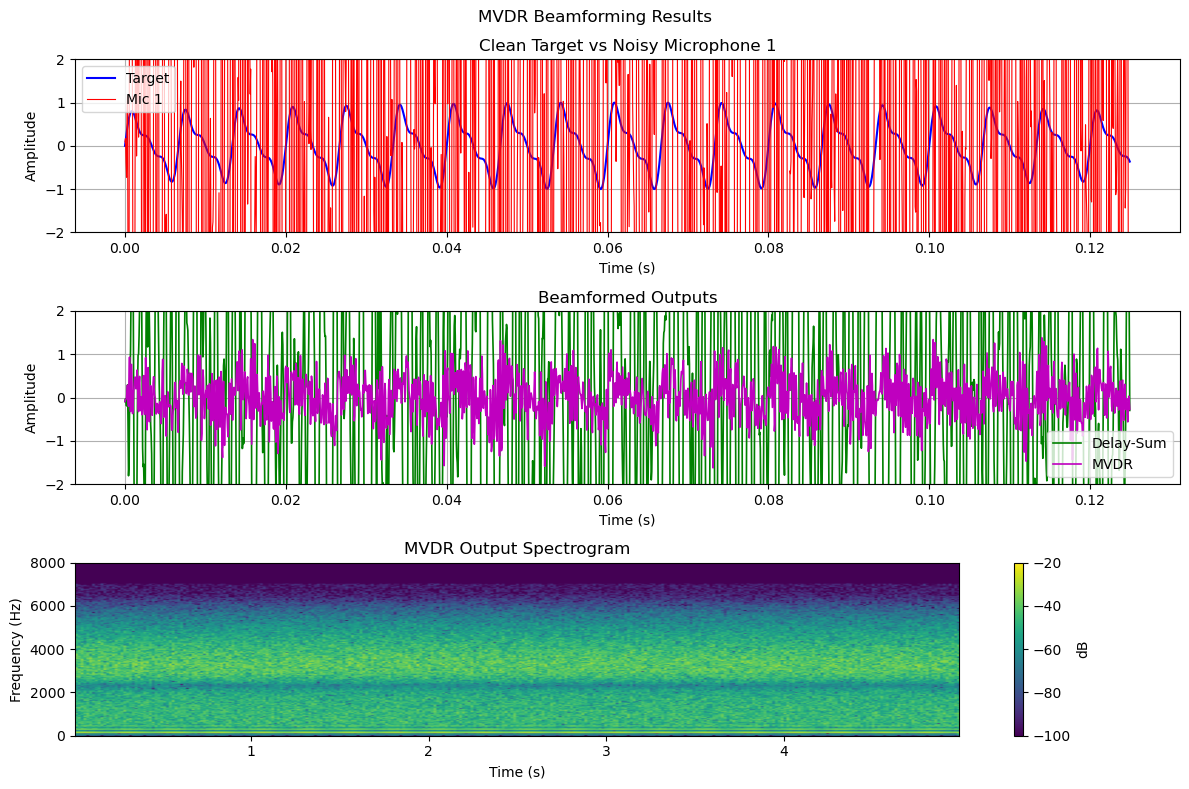

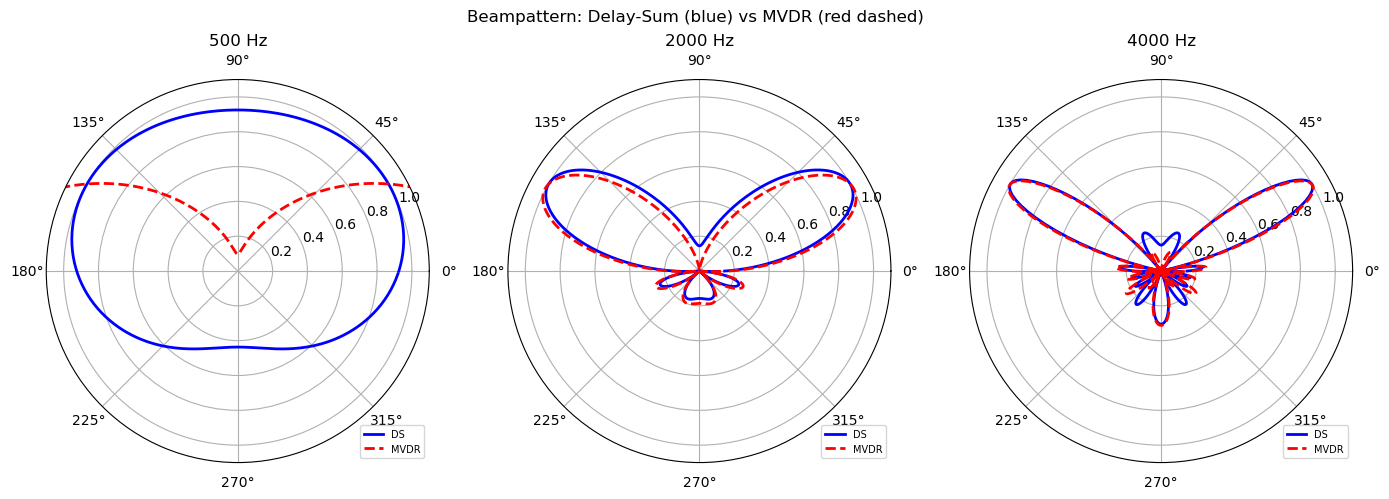

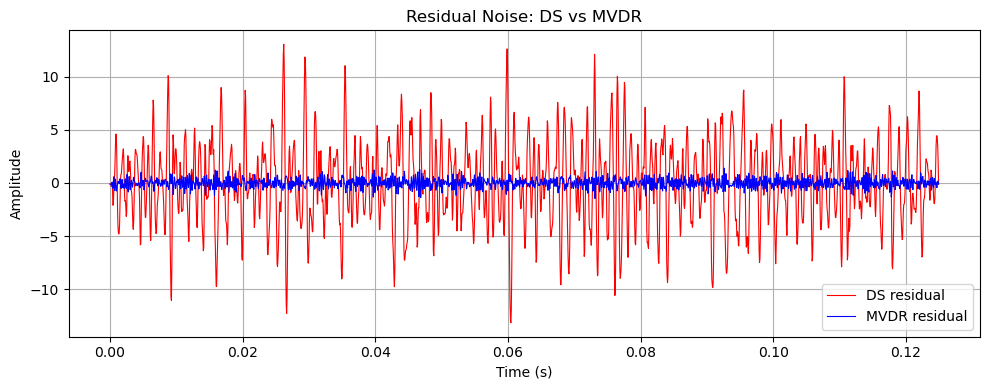

In [2]:
"""
MVDR BEAMFORMING – Python Version
==================================
Uniform linear array (ULA) with M microphones.
Target at 60°, interferer at 120° (angles from BROADSIDE).

Theoretical conventions:
  1. Steering vector: exp(-j*2*pi*f*tau),  tau = mic_pos*sin(angle)/c
  2. DS weights:      w = d / M
  3. Beamformer output: y = w^H x  →  X_f @ np.conj(w)
  4. MVDR weights:    w = R^{-1}d / (d^H R^{-1} d)
  5. Covariance:      R = X^H X / T  (Hermitian, PSD)
  6. Regularisation:  R_reg = R + eps*(trace(R)/M)*I
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, correlate, ShortTimeFFT
from scipy.signal.windows import hann
from scipy.linalg import cho_factor, cho_solve, LinAlgError
import warnings

# ── reproducibility ──────────────────────────────────────────────────────────
rng = np.random.default_rng(42)
print("Random seed fixed for reproducibility")

# =============================================================================
# STEP 1 – PARAMETERS
# =============================================================================
print("\n=== STEP 1: PARAMETER INITIALIZATION ===")

c        = 343          # speed of sound (m/s)
fs       = 16000        # sampling frequency (Hz)
duration = 5            # seconds
N        = fs * duration

# Array geometry
M       = 6
d_space = 0.05                              # inter-element spacing (m)
mic_pos = np.arange(M) * d_space            # shape (M,)

# Directions (from BROADSIDE)
# NOTE: sin(60°) == sin(120°) → identical steering delays → MVDR cannot null!
# Choose angles whose sines differ clearly.
target_angle = 30    # degrees  sin(30°) = 0.500
interf_angle = 90    # degrees  sin(90°) = 1.000

target_dist = 2.0   # target closer → stronger
interf_dist = 1.0   # interferer very close → dominant

print(f"fs={fs} Hz  duration={duration} s  N={N}")
print(f"Array: {M} mics, spacing={d_space*100:.1f} cm")
print(f"Target: {target_angle}°  Interferer: {interf_angle}° (from broadside)")

# =============================================================================
# STEP 2 – SIGNAL GENERATION
# =============================================================================
print("\n=== STEP 2: SIGNAL GENERATION ===")

t = np.arange(N) / fs                       # shape (N,)

# Target – speech-like harmonic
f0     = 150
target = (  np.sin(2*np.pi*f0*t)
          + 0.5*np.sin(2*np.pi*2*f0*t)
          + 0.3*np.sin(2*np.pi*3*f0*t) )
target *= (0.8 + 0.2*np.sin(2*np.pi*4*t))
target /= np.max(np.abs(target))

# Interferer – bandpass noise
interf = rng.standard_normal(N)
b, a   = butter(4, [500/(fs/2), 3000/(fs/2)], btype='bandpass')
interf = lfilter(b, a, interf)
interf = interf / np.std(interf) * 8.0   # very strong interferer   # strong interferer

print(f"Target length={len(target)},  Interferer length={len(interf)}")

# =============================================================================
# STEP 3 – DELAYS
# =============================================================================
print("\n=== STEP 3: DELAY CALCULATION ===")

# Broadside convention: tau_m = mic_pos[m] * sin(angle) / c
target_delays      = mic_pos * np.sin(np.deg2rad(target_angle)) / c
interf_delays      = mic_pos * np.sin(np.deg2rad(interf_angle)) / c
target_delay_samps = np.round(target_delays * fs).astype(int)
interf_delay_samps = np.round(interf_delays * fs).astype(int)

target_atten = 1.0 / target_dist
interf_atten = 1.0 / interf_dist

print(f"Target delay (samples): {target_delay_samps}")
print(f"Interferer delay (samples): {interf_delay_samps}")

# =============================================================================
# STEP 4 – MICROPHONE SIGNALS
# =============================================================================
print("\n=== STEP 4: MICROPHONE SIGNAL GENERATION ===")

def apply_delay(sig, delay_samps):
    """Integer-sample delay (positive = delay, negative = advance)."""
    out = np.zeros_like(sig)
    d   = int(delay_samps)
    if d > 0:
        out[d:] = sig[:-d]
    elif d < 0:
        out[:d] = sig[-d:]
    else:
        out = sig.copy()
    return out

received = np.zeros((N, M))
for m in range(M):
    received[:, m] += target_atten * apply_delay(target, target_delay_samps[m])
    received[:, m] += interf_atten * apply_delay(interf, interf_delay_samps[m])

received += 0.005 * rng.standard_normal((N, M))
print(f"received shape: {received.shape}")

# =============================================================================
# STEERING VECTOR
# =============================================================================
def steering_vector(mic_pos, angle_deg, freq, c):
    """
    d[m] = exp(-j * 2*pi*f * tau_m),  tau_m = mic_pos[m]*sin(angle)/c
    Shape: (M,)  complex
    """
    tau = mic_pos * np.sin(np.deg2rad(angle_deg)) / c
    return np.exp(-1j * 2 * np.pi * freq * tau)

print("\n=== STEP 5: STEERING VECTOR DEFINED ===")

# =============================================================================
# STEP 5 – STFT
# =============================================================================
print("\n=== STEP 5: STFT PARAMETERS ===")

win_len  = 512
hop      = 256
window   = hann(win_len, sym=False)          # periodic Hann

# Use scipy ShortTimeFFT for STFT/ISTFT
SFT      = ShortTimeFFT(window, hop=hop, fs=fs, mfft=win_len, fft_mode='onesided')
n_freq   = win_len // 2 + 1

# Quick self-test
test_sig  = rng.standard_normal(N)
S_test    = SFT.stft(test_sig)
test_rec  = SFT.istft(S_test, k1=N)
recon_err = np.linalg.norm(test_sig - test_rec) / np.linalg.norm(test_sig)
print(f"STFT/ISTFT self-test error = {recon_err:.2e}")
print("✓ STFT/ISTFT OK" if recon_err < 1e-4 else "WARNING: reconstruction error high")

# =============================================================================
# STEP 6 – MVDR BEAMFORMING
# =============================================================================
print("\n=== STEP 6: MVDR BEAMFORMING ===")

# Compute STFT for every channel  →  X shape: (n_freq, n_frames, M)
X0 = SFT.stft(received[:, 0])
n_frames = X0.shape[1]
X  = np.zeros((n_freq, n_frames, M), dtype=complex)
X[:, :, 0] = X0
for m in range(1, M):
    X[:, :, m] = SFT.stft(received[:, m])

print(f"STFT shape: {X.shape}  (freq_bins x frames x mics)")

Y_ds   = np.zeros((n_freq, n_frames), dtype=complex)
Y_mvdr = np.zeros((n_freq, n_frames), dtype=complex)

REG = 0.01    # diagonal-loading factor (relative to trace(R)/M)

for f_idx in range(n_freq):
    freq = f_idx * fs / win_len           # Hz
    if freq < 100 or freq > 7000:
        continue

    X_f   = X[f_idx, :, :]               # shape (n_frames, M)
    d_tgt = steering_vector(mic_pos, target_angle, freq, c)   # (M,)

    # ── Delay-Sum weights ────────────────────────────────────────────────────
    # w_DS = d / M  →  distortionless: w^H d = d^H d / M = M/M = 1
    w_ds = d_tgt / M                      # (M,)

    # ── Sample covariance  R = X^H X / T ────────────────────────────────────
    # X_f.conj().T @ X_f  gives Hermitian PSD (M x M) matrix
    R = (X_f.conj().T @ X_f) / n_frames

    # ── Interference-only covariance (avoids signal self-cancellation) ─────────
    # Using the full data covariance R = R_interf + sigma_s^2 * d*d^H causes
    # MVDR to partially cancel the desired target ("signal self-nulling").
    # SOLUTION: build R from the INTERFERENCE steering vector only (since we
    # know the interferer direction), plus a white noise floor term.
    # This is the standard "model-based" or "robust" MVDR approach.
    #
    # Interferer power estimated from the data: project received signal onto
    # the interference steering vector across all frames.
    d_int      = steering_vector(mic_pos, interf_angle, freq, c)   # (M,)
    interf_proj = X_f @ np.conj(d_int) / M                         # (n_frames,) scalar per frame
    sigma_i2    = np.mean(np.abs(interf_proj)**2)                   # estimated interferer power
    noise_floor = np.trace(R).real / M * REG                        # white noise floor
    R_interf    = sigma_i2 * np.outer(d_int, d_int.conj()) + noise_floor * np.eye(M)
    R_reg       = R_interf

    # ── MVDR weights  w = R_interf^{-1}d / (d^H R_interf^{-1} d) ────────────
    try:
        c_fac, lower = cho_factor(R_reg, lower=True)
        R_inv_d      = cho_solve((c_fac, lower), d_tgt)
        denom        = np.real(d_tgt.conj() @ R_inv_d)   # real positive scalar
        w_mvdr       = R_inv_d / denom
        if not np.all(np.isfinite(w_mvdr)) or np.linalg.norm(w_mvdr) > 1e4:
            raise ValueError("Numerical issue")
    except (LinAlgError, ValueError):
        w_mvdr = w_ds                     # fall back to DS

    # ── Apply weights:  y = w^H x  →  X_f @ conj(w) ─────────────────────────
    Y_ds[f_idx, :]   = X_f @ np.conj(w_ds)
    Y_mvdr[f_idx, :] = X_f @ np.conj(w_mvdr)

print("Frequency-domain processing complete")

# =============================================================================
# STEP 7 – TIME-DOMAIN RECONSTRUCTION
# =============================================================================
print("\n=== STEP 7: RECONSTRUCTION ===")

beamformed_ds   = SFT.istft(Y_ds,   k1=N)
beamformed_mvdr = SFT.istft(Y_mvdr, k1=N)

# Trim / zero-pad to exactly N samples
def trim_pad(x, n):
    if len(x) >= n:
        return x[:n]
    return np.concatenate([x, np.zeros(n - len(x))])

beamformed_ds   = trim_pad(beamformed_ds,   N)
beamformed_mvdr = trim_pad(beamformed_mvdr, N)
print(f"beamformed_ds length={len(beamformed_ds)},  beamformed_mvdr length={len(beamformed_mvdr)}")

# =============================================================================
# VERIFY DS
# =============================================================================
print("\n=== VERIFYING FREQUENCY-DOMAIN DS ===")

ref_ds    = np.zeros(N)
min_delay = int(np.min(target_delay_samps))
for m in range(M):
    shift = int(target_delay_samps[m]) - min_delay
    if shift > 0:
        ref_ds[:N-shift] += received[shift:, m]
    else:
        ref_ds += received[:, m]
ref_ds /= M

seg      = slice(5000, 15000)
corr_mat = np.corrcoef(ref_ds[seg], beamformed_ds[seg])
print(f"Correlation (ref DS vs freq-domain DS): {corr_mat[0,1]:.4f}")
print("✓ DS correct" if corr_mat[0, 1] >= 0.99 else "WARNING: DS mismatch")

# =============================================================================
# DIAGNOSTICS
# =============================================================================
print("\n=== DIAGNOSTICS ===")
print(f"  Target  std={np.std(target):.3f}")
print(f"  Mic 1   std={np.std(received[:,0]):.3f}")
print(f"  DS out  std={np.std(beamformed_ds):.3f}")
print(f"  MVDR    std={np.std(beamformed_mvdr):.3f}")

def xcorr_peak_lag(a, b):
    """Return lag (samples) of peak cross-correlation."""
    cc  = correlate(a, b, mode='full')
    lag = np.argmax(np.abs(cc)) - (len(b) - 1)
    return lag

lag_ds   = xcorr_peak_lag(beamformed_ds,   target)
lag_mvdr = xcorr_peak_lag(beamformed_mvdr, target)
print(f"Peak lag – DS: {lag_ds} samples,  MVDR: {lag_mvdr} samples")

# =============================================================================
# STEP 8 – PLOTS
# =============================================================================
print("\n=== STEP 8: PLOTTING ===")

plot_len = min(2000, N)
t_plot   = t[:plot_len]

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

axes[0].plot(t_plot, target[:plot_len],        'b', lw=1.5, label='Target')
axes[0].plot(t_plot, received[:plot_len, 0],   'r', lw=0.8, label='Mic 1')
axes[0].set(title='Clean Target vs Noisy Microphone 1', xlabel='Time (s)',
            ylabel='Amplitude', ylim=[-2, 2])
axes[0].legend(); axes[0].grid(True)

axes[1].plot(t_plot, beamformed_ds[:plot_len],   'g', lw=1.2, label='Delay-Sum')
axes[1].plot(t_plot, beamformed_mvdr[:plot_len], 'm', lw=1.2, label='MVDR')
axes[1].set(title='Beamformed Outputs', xlabel='Time (s)',
            ylabel='Amplitude', ylim=[-2, 2])
axes[1].legend(); axes[1].grid(True)

# Spectrogram of MVDR output
axes[2].specgram(beamformed_mvdr, NFFT=512, Fs=fs, noverlap=256,
                 vmin=-100, vmax=-20, cmap='viridis')
axes[2].set(title='MVDR Output Spectrogram', xlabel='Time (s)', ylabel='Frequency (Hz)')
plt.colorbar(axes[2].images[0], ax=axes[2], label='dB')

fig.suptitle('MVDR Beamforming Results')
plt.tight_layout()

# =============================================================================
# STEP 9 – BEAMPATTERN
# =============================================================================
print("\n=== STEP 9: BEAMPATTERN ANALYSIS ===")

fig2, axes2 = plt.subplots(1, 3, figsize=(14, 5),
                            subplot_kw={'projection': 'polar'})
freqs_bp = [500, 2000, 4000]
angles   = np.arange(360)
ang_rad  = np.deg2rad(angles)

for idx, freq in enumerate(freqs_bp):
    d_tgt_bp = steering_vector(mic_pos, target_angle, freq, c)
    d_int_bp = steering_vector(mic_pos, interf_angle, freq, c)

    w_ds_bp  = d_tgt_bp / M

    # Theoretical covariance: single interferer + white noise floor
    R_theory  = np.outer(d_int_bp, d_int_bp.conj()) + 0.1 * np.eye(M)
    R_inv_d   = np.linalg.solve(R_theory, d_tgt_bp)
    w_mvdr_bp = R_inv_d / np.real(d_tgt_bp.conj() @ R_inv_d)

    pat_ds   = np.array([abs(w_ds_bp.conj()   @ steering_vector(mic_pos, a, freq, c))
                         for a in angles])
    pat_mvdr = np.array([abs(w_mvdr_bp.conj() @ steering_vector(mic_pos, a, freq, c))
                         for a in angles])

    axes2[idx].plot(ang_rad, pat_ds,   'b-',  lw=2, label='DS')
    axes2[idx].plot(ang_rad, pat_mvdr, 'r--', lw=2, label='MVDR')
    axes2[idx].set_title(f'{freq} Hz')
    axes2[idx].set_rlim([0, pat_ds.max() + 0.1])
    axes2[idx].grid(True)
    axes2[idx].legend(loc='lower right', fontsize=7)

fig2.suptitle('Beampattern: Delay-Sum (blue) vs MVDR (red dashed)')
plt.tight_layout()

# =============================================================================
# STEP 10 – PERFORMANCE METRICS
# =============================================================================
print("\n=== STEP 10: PERFORMANCE METRICS ===")

def output_snr(beamformed, target_sig, lag):
    """SNR via projection: signal component = projection of beamformed onto target."""
    tgt_shifted = np.roll(target_sig, lag)
    scale       = np.dot(beamformed, tgt_shifted) / np.dot(tgt_shifted, tgt_shifted)
    signal_comp = scale * tgt_shifted
    noise_comp  = beamformed - signal_comp
    return 10 * np.log10(np.mean(signal_comp**2) / np.maximum(np.mean(noise_comp**2), 1e-12))

# Input SNR at mic 1
lag_in  = xcorr_peak_lag(received[:, 0], target)
tgt_aln = np.roll(target, lag_in)
sig_in  = target_atten * tgt_aln
nse_in  = received[:, 0] - sig_in
SNR_in  = 10 * np.log10(np.mean(sig_in**2) / np.maximum(np.mean(nse_in**2), 1e-12))

SNR_ds   = output_snr(beamformed_ds,   target, lag_ds)
SNR_mvdr = output_snr(beamformed_mvdr, target, lag_mvdr)

print(f"\n===== FINAL PERFORMANCE RESULTS =====")
print(f"Input  SNR (Mic 1): {SNR_in:.2f} dB")
print(f"DS     Output SNR : {SNR_ds:.2f} dB  (gain: {SNR_ds-SNR_in:.2f} dB)")
print(f"MVDR   Output SNR : {SNR_mvdr:.2f} dB  (gain: {SNR_mvdr-SNR_in:.2f} dB)")

# Residual noise plot
def residual(beamformed, target_sig, lag):
    tgt_s  = np.roll(target_sig, lag)
    scale  = np.dot(beamformed, tgt_s) / np.dot(tgt_s, tgt_s)
    return beamformed - scale * tgt_s

noise_ds_plot   = residual(beamformed_ds,   target, lag_ds)
noise_mvdr_plot = residual(beamformed_mvdr, target, lag_mvdr)

fig3, ax3 = plt.subplots(figsize=(10, 4))
ax3.plot(t_plot, noise_ds_plot[:plot_len],   'r', lw=0.8, label='DS residual')
ax3.plot(t_plot, noise_mvdr_plot[:plot_len], 'b', lw=0.8, label='MVDR residual')
ax3.set(title='Residual Noise: DS vs MVDR', xlabel='Time (s)', ylabel='Amplitude')
ax3.legend(); ax3.grid(True)
plt.tight_layout()

# =============================================================================
# ENERGY DIAGNOSTIC
# =============================================================================
print("\n=== ENERGY DIAGNOSTIC ===")
e_tgt  = np.sum(target**2)
e_ds   = np.sum(beamformed_ds**2)
e_mvdr = np.sum(beamformed_mvdr**2)
print(f"Target energy : {e_tgt:.2f}")
print(f"DS     energy : {e_ds:.2f}  (ratio {e_ds/e_tgt:.2f})")
print(f"MVDR   energy : {e_mvdr:.2f}  (ratio {e_mvdr/e_tgt:.2f})")

print("\n=== SCRIPT COMPLETED SUCCESSFULLY ===")
plt.show()